In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate_mlp import J, J_prime

%load_ext autoreload
%autoreload 2

In [3]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/aerial"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/aerial/03_model_weights/resnet"
MODEL_NAME = "20240503_1321"

In [4]:
import yaml

# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [5]:
IMG_SIZE = 64
RESNET_EMBEDDING_SIZE = config["model"]["embedding_size"]
UNET_EMBEDDING_SIZE = 512

In [6]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")

DIR_CAL_UNET_EMB = os.path.join(BASE_DIR, "04_predictions/cal/embeddings",)
DIR_TEST_UNET_EMB = DIR_CAL_UNET_EMB.replace("cal", "test")



In [7]:
def load_data(pred_probas_dir, res_emb_dir, unet_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    unet_emb = np.zeros((len(os.listdir(unet_emb_dir)), UNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, unet_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(unet_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        unet_emb[i] = np.load(os.path.join(unet_emb_dir, unet_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, unet_emb, labels


In [8]:
cal_pred_probas, cal_res_emb, cal_unet_emb, cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_UNET_EMB, DIR_CAL_LABELS
)


1500it [00:12, 117.48it/s]


In [9]:
test_pred_probas, test_res_emb, test_unet_emb, test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_UNET_EMB, DIR_TEST_LABELS
)

0it [00:00, ?it/s]

2300it [00:04, 494.01it/s]


In [10]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]
cal_unet_emb = cal_unet_emb[index_not_empy]

In [11]:
ALPHA = .1
N = len(cal_labels)
REGULARIZATION = "ridge"

In [12]:
def grid_search_lambda(labels, pred_probas, embeddings, embedding_size):
    lambdas = [0, 0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
    best_dist = np.inf
    best_lambda = None
    cv = len(lambdas)
    # get cv indices
    indices = np.arange(len(labels))
    np.random.seed(42)
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    for i, lambda_ in enumerate(tqdm(lambdas)):
        test_labels = labels[indices[i]]
        test_pred_probas = pred_probas[indices[i]]
        test_res_emb = embeddings[indices[i]]
        cal_labels = np.concatenate([labels[indices[j]] for j in range(cv) if j != i])
        cal_pred_probas = np.concatenate([pred_probas[indices[j]] for j in range(cv) if j != i])
        cal_res_emb = np.concatenate([embeddings[indices[j]] for j in range(cv) if j != i])
        
        result = minimize(
            J, np.random.uniform(0, 1, embedding_size),
            method="SLSQP",
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, len(cal_labels), REGULARIZATION, lambda_), jac=J_prime,
            options={"disp": False, "maxiter": 10000}
        )
        ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        test_res_emb.shape
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
        if (np.abs(recall_test - (1 - ALPHA))) < best_dist:
            best_dist = np.abs(recall_test - (1 - ALPHA))
            best_lambda = lambda_
        
    return best_lambda, best_dist
        

# Fit CRC

In [13]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [14]:
mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
for i in tqdm(range(len(cal_pred_probas))):
    X, y = cal_pred_probas[i], cal_labels[i]
    mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])

100%|██████████| 1221/1221 [00:03<00:00, 365.70it/s]


In [15]:
_, _ = mapie_crc.predict(test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
th_crc = mapie_crc.lambdas_star
th_crc

array([0.18])

# Fit multi-accurate with ResNet embedding

In [16]:
import torch

#import mse loss

from torch.nn import MSELoss

# create a MLP regressor with 5 layers with custom loss

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc5 = torch.nn.Linear(256, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc5(x)
        return x
    
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, mask, mask_pred, pred_th, alpha):
        # Loss with ridge regularization
        
        return J(mask, mask_pred, pred_th, alpha)

def train_mlp(mask, mask_pred, emb, alpha, hidden_size=100, lr=1e-3, n_epochs=1000):
    emb = torch.tensor(emb, dtype=torch.float32)
    mask = torch.tensor(mask, dtype=torch.float32, requires_grad=False)
    mask_pred = torch.tensor(mask_pred, dtype=torch.float32, requires_grad=False)
    model = MLP(emb.shape[1], hidden_size, 1)
    criterion = CustomLoss()
    # criterion = MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        th_pred = model(emb)

        loss = criterion(mask, mask_pred, th_pred, alpha)
        if len(loss.shape) == 1:
            loss = loss[:, None]
        # loss = criterion(th_pred, torch.zeros_like(th_pred) + alpha)
        print(f"Epoch {epoch}, loss {loss.mean()} - mean-th {th_pred.mean()}")
        th_pred.backward(loss)
        optimizer.step()
    return model


In [150]:
model = train_mlp(cal_labels, cal_pred_probas, cal_res_emb, .1, hidden_size=1000, lr=1e-3, n_epochs=100)


Epoch 0, loss 4.745213508605957 - mean-th 0.07554832100868225
Epoch 1, loss 1.7262251377105713 - mean-th -16.57902717590332
Epoch 2, loss 10.0 - mean-th -105534.5546875
Epoch 3, loss 10.0 - mean-th -9.09729059869305e+19
Epoch 4, loss 10.0 - mean-th -inf
Epoch 5, loss 100.0819091796875 - mean-th nan
Epoch 6, loss 100.0819091796875 - mean-th nan


KeyboardInterrupt: 

In [138]:
J(cal_labels, cal_pred_probas, torch.zeros(len(cal_labels)), .1).mean()

tensor(-9.9181)

In [95]:
from torch import nn
from torch.autograd import Variable

class NNet(nn.Module):   
    def __init__(self, input_size, hidden_size):
        super().__init__()
        

        self.iter = 0
        # The loss function could be MSE or BCELoss depending on the problem
        # We leave the optimizer empty for now to assign flexibly
        self.optim = None

        
        self.fc1 = torch.nn.Linear(input_size, hidden_size)

        self.fc5 = torch.nn.Linear(hidden_size, 1)

        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc5(x)
        return x
    
    def train(self, data_loader, epochs):

        for epoch in range(epochs):
            running_loss = self._train_iteration(data_loader)            
            print('[%d] loss: %.3f' %
                (epoch + 1, running_loss))
            
            
                
    def _train_iteration(self,data_loader):
        running_loss = 0.0
        emb, mask, mask_pred = data_loader
            
        emb = torch.tensor(emb, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        mask_pred = torch.tensor(mask_pred, dtype=torch.float32)
            
        def closure():
            if torch.is_grad_enabled():
                self.optim.zero_grad()
            output = self(emb)
            loss = J(mask, mask_pred, output, ALPHA)
            # if loss.requires_grad:
            loss.backward()
            return loss.mean()
        
        self.optim.step(closure)
        
        # calculate the loss again for monitoring
        loss = closure()
        running_loss += loss.item()
               
        return running_loss
    
    # I like to include a sklearn like predict method for convenience
    def predict(self, X):
        X = torch.Tensor(X)
        return self(X).detach().numpy().squeeze()

In [98]:
model = NNet(UNET_EMBEDDING_SIZE, 100)
model.optim = torch.optim.LBFGS(model.parameters(), lr=0.1)
model.train((cal_unet_emb, cal_labels, cal_pred_probas), 5)

RuntimeError: output with shape [] doesn't match the broadcast shape [1]

In [75]:
from torch import nn
from torch.autograd import Variable

class NNet2(nn.Module):   
    def __init__(self, input_size, hidden_size):
        super().__init__()
        

        self.iter = 0
        # The loss function could be MSE or BCELoss depending on the problem
        # We leave the optimizer empty for now to assign flexibly
        self.optim = None

        
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc5 = torch.nn.Linear(hidden_size, 1)

        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc5(x)
        return x
    
    def train(self, data_loader, epochs):

        for epoch in range(epochs):
            running_loss = self._train_iteration(data_loader)            
            print('[%d] loss: %.3f' %
                (epoch + 1, running_loss))
            
            
                
    def _train_iteration(self,data_loader):
        running_loss = 0.0
        x, y = data_loader
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)       
            
        def closure():
            if torch.is_grad_enabled():
                self.optim.zero_grad()
            output = self(x)
            loss = torch.abs(output - y).mean()
            if loss.requires_grad:
                loss.backward()
            return loss.mean()
        
        self.optim.step(closure)
        
        # calculate the loss again for monitoring
        loss = closure()
        running_loss += loss.item()
               
        return running_loss
    
    # I like to include a sklearn like predict method for convenience
    def predict(self, X):
        X = torch.Tensor(X)
        return self(X).detach().numpy().squeeze()

In [76]:
x.shape

(1000, 1)

In [83]:
x = np.linspace(0, 10, 1000)[:, None]
y = np.sin(x)

model = NNet2(1, 50)
model.optim = torch.optim.LBFGS(model.parameters(), lr=0.001)
model.train((x, y), 500)


[1] loss: 0.635
[2] loss: 0.632
[3] loss: 0.622
[4] loss: 0.621
[5] loss: 0.597
[6] loss: 0.593
[7] loss: 0.593
[8] loss: 0.569
[9] loss: 0.565
[10] loss: 0.565
[11] loss: 0.564
[12] loss: 0.560
[13] loss: 0.559
[14] loss: 0.554
[15] loss: 0.554
[16] loss: 0.551
[17] loss: 0.536
[18] loss: 0.535
[19] loss: 0.535
[20] loss: 0.526
[21] loss: 0.522
[22] loss: 0.521
[23] loss: 0.514
[24] loss: 0.509
[25] loss: 0.501
[26] loss: 0.499
[27] loss: 0.497
[28] loss: 0.492
[29] loss: 0.489
[30] loss: 0.449
[31] loss: 0.444
[32] loss: 0.440
[33] loss: 0.435
[34] loss: 0.426
[35] loss: 0.424
[36] loss: 0.422
[37] loss: 0.413
[38] loss: 0.409
[39] loss: 0.407
[40] loss: 0.406
[41] loss: 0.400
[42] loss: 0.396
[43] loss: 0.394
[44] loss: 0.390
[45] loss: 0.382
[46] loss: 0.379
[47] loss: 0.370
[48] loss: 0.353
[49] loss: 0.351
[50] loss: 0.347
[51] loss: 0.329
[52] loss: 0.326
[53] loss: 0.320
[54] loss: 0.306
[55] loss: 0.305
[56] loss: 0.304
[57] loss: 0.303
[58] loss: 0.293
[59] loss: 0.286
[60] l

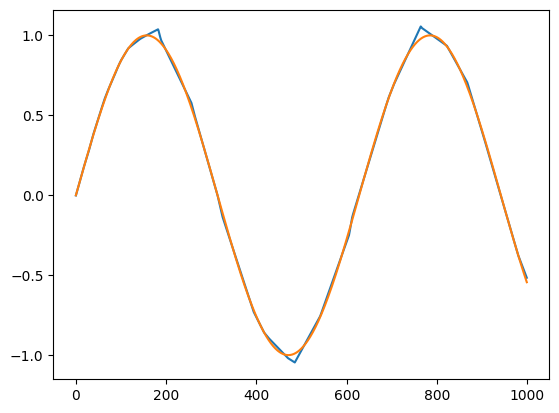

In [85]:
plt.plot(model.predict(x))
plt.plot(y)

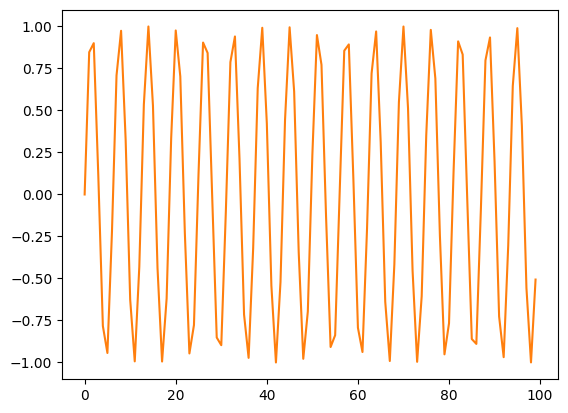

In [53]:
plt.plot(model.predict(x))
plt.plot(y)

In [77]:
model = train_mlp(cal_labels, cal_pred_probas, cal_res_emb, .3, hidden_size=100, lr=1e-1, n_epochs=10)


Epoch 0, loss -26.097761154174805


TypeError: LBFGS.step() missing 1 required positional argument: 'closure'

In [49]:
y.shape

(100, 1, 100)

In [75]:
model(torch.tensor(test_res_emb, dtype=torch.float32)).detach().numpy().max()

0.0

In [47]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100, 100), max_iter=1000, alpha=0, solver="adam", learning_rate="adaptive", learning_rate_init=1e-3)

In [83]:
cal_pred_probas.shape


(1221, 64, 64)

In [16]:
lambda_resnet, dist_resnet = grid_search_lambda(cal_labels, cal_pred_probas, cal_res_emb, RESNET_EMBEDDING_SIZE)
print(lambda_resnet, dist_resnet)
result_res = minimize(
    J, np.random.uniform(0, 1, RESNET_EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N, REGULARIZATION, lambda_resnet), jac=J_prime,
    options={"disp": True, "maxiter": 1000}, tol=1e-10
)
ths_res = (test_res_emb @ result_res.x).reshape(-1, 1, 1)

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_1689156/2137850341.py:29: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
100%|██████████| 8/8 [00:26<00:00,  3.32s/it]

0.001 0.0023552829751984916


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.923702775476343
            Iterations: 9
            Function evaluations: 10
            Gradient evaluations: 9


# Fit multi-accurante with UNet embedding

In [17]:
lambda_unet, dist_unet = grid_search_lambda(cal_labels, cal_pred_probas, cal_unet_emb, UNET_EMBEDDING_SIZE)
print(lambda_unet, dist_unet)
result_unet = minimize(
    J, np.random.uniform(0, 1, UNET_EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_unet_emb, ALPHA, N, REGULARIZATION, lambda_unet), jac=J_prime,
    options={"disp": True, "maxiter": 1000}, tol=1e-10
)
ths_unet = (test_unet_emb @ result_unet.x).reshape(-1, 1, 1)


  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_1689156/2137850341.py:29: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
100%|██████████| 8/8 [03:25<00:00, 25.70s/it]

0 0.004940185811699749


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.928829098531546
            Iterations: 164
            Function evaluations: 205
            Gradient evaluations: 164


In [34]:
ths_unet = np.maximum(ths_unet, 0.1)

# Apply thresholds on pred-probas

In [35]:
y_pred_test_th_unet = (test_pred_probas >= ths_unet).astype(int)
recall_unet = (y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

y_pred_test_th_resnet = (test_pred_probas >= ths_res).astype(int)
recall_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

y_pred_test_th_crc = (test_pred_probas >= th_crc).astype(int)
recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))

/tmp/ipykernel_1689156/3013443579.py:2: RuntimeWarning: invalid value encountered in divide
  recall_unet = (y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
/tmp/ipykernel_1689156/3013443579.py:5: RuntimeWarning: invalid value encountered in divide
  recall_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
/tmp/ipykernel_1689156/3013443579.py:8: RuntimeWarning: invalid value encountered in divide
  recall_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))


In [36]:
precision_test_unet = np.nan_to_num((y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_unet.sum(axis=(1, 2)), nan=1)
precision_test_resnet = np.nan_to_num((y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2)), nan=1)
precision_test_crc = np.nan_to_num((y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2)), nan=1)


/tmp/ipykernel_1689156/1801235197.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_unet = np.nan_to_num((y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_unet.sum(axis=(1, 2)), nan=1)
/tmp/ipykernel_1689156/1801235197.py:2: RuntimeWarning: invalid value encountered in divide
  precision_test_resnet = np.nan_to_num((y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2)), nan=1)
/tmp/ipykernel_1689156/1801235197.py:3: RuntimeWarning: invalid value encountered in divide
  precision_test_crc = np.nan_to_num((y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2)), nan=1)


In [37]:
precision_test_unet = (y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_unet.sum(axis=(1, 2))
precision_test_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2))
precision_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


/tmp/ipykernel_1689156/3495102333.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test_unet = (y_pred_test_th_unet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_unet.sum(axis=(1, 2))
/tmp/ipykernel_1689156/3495102333.py:2: RuntimeWarning: invalid value encountered in divide
  precision_test_resnet = (y_pred_test_th_resnet * test_labels).sum(axis=(1, 2)) / y_pred_test_th_resnet.sum(axis=(1, 2))
/tmp/ipykernel_1689156/3495102333.py:3: RuntimeWarning: invalid value encountered in divide
  precision_test_crc = (y_pred_test_th_crc * test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))


# Plot results

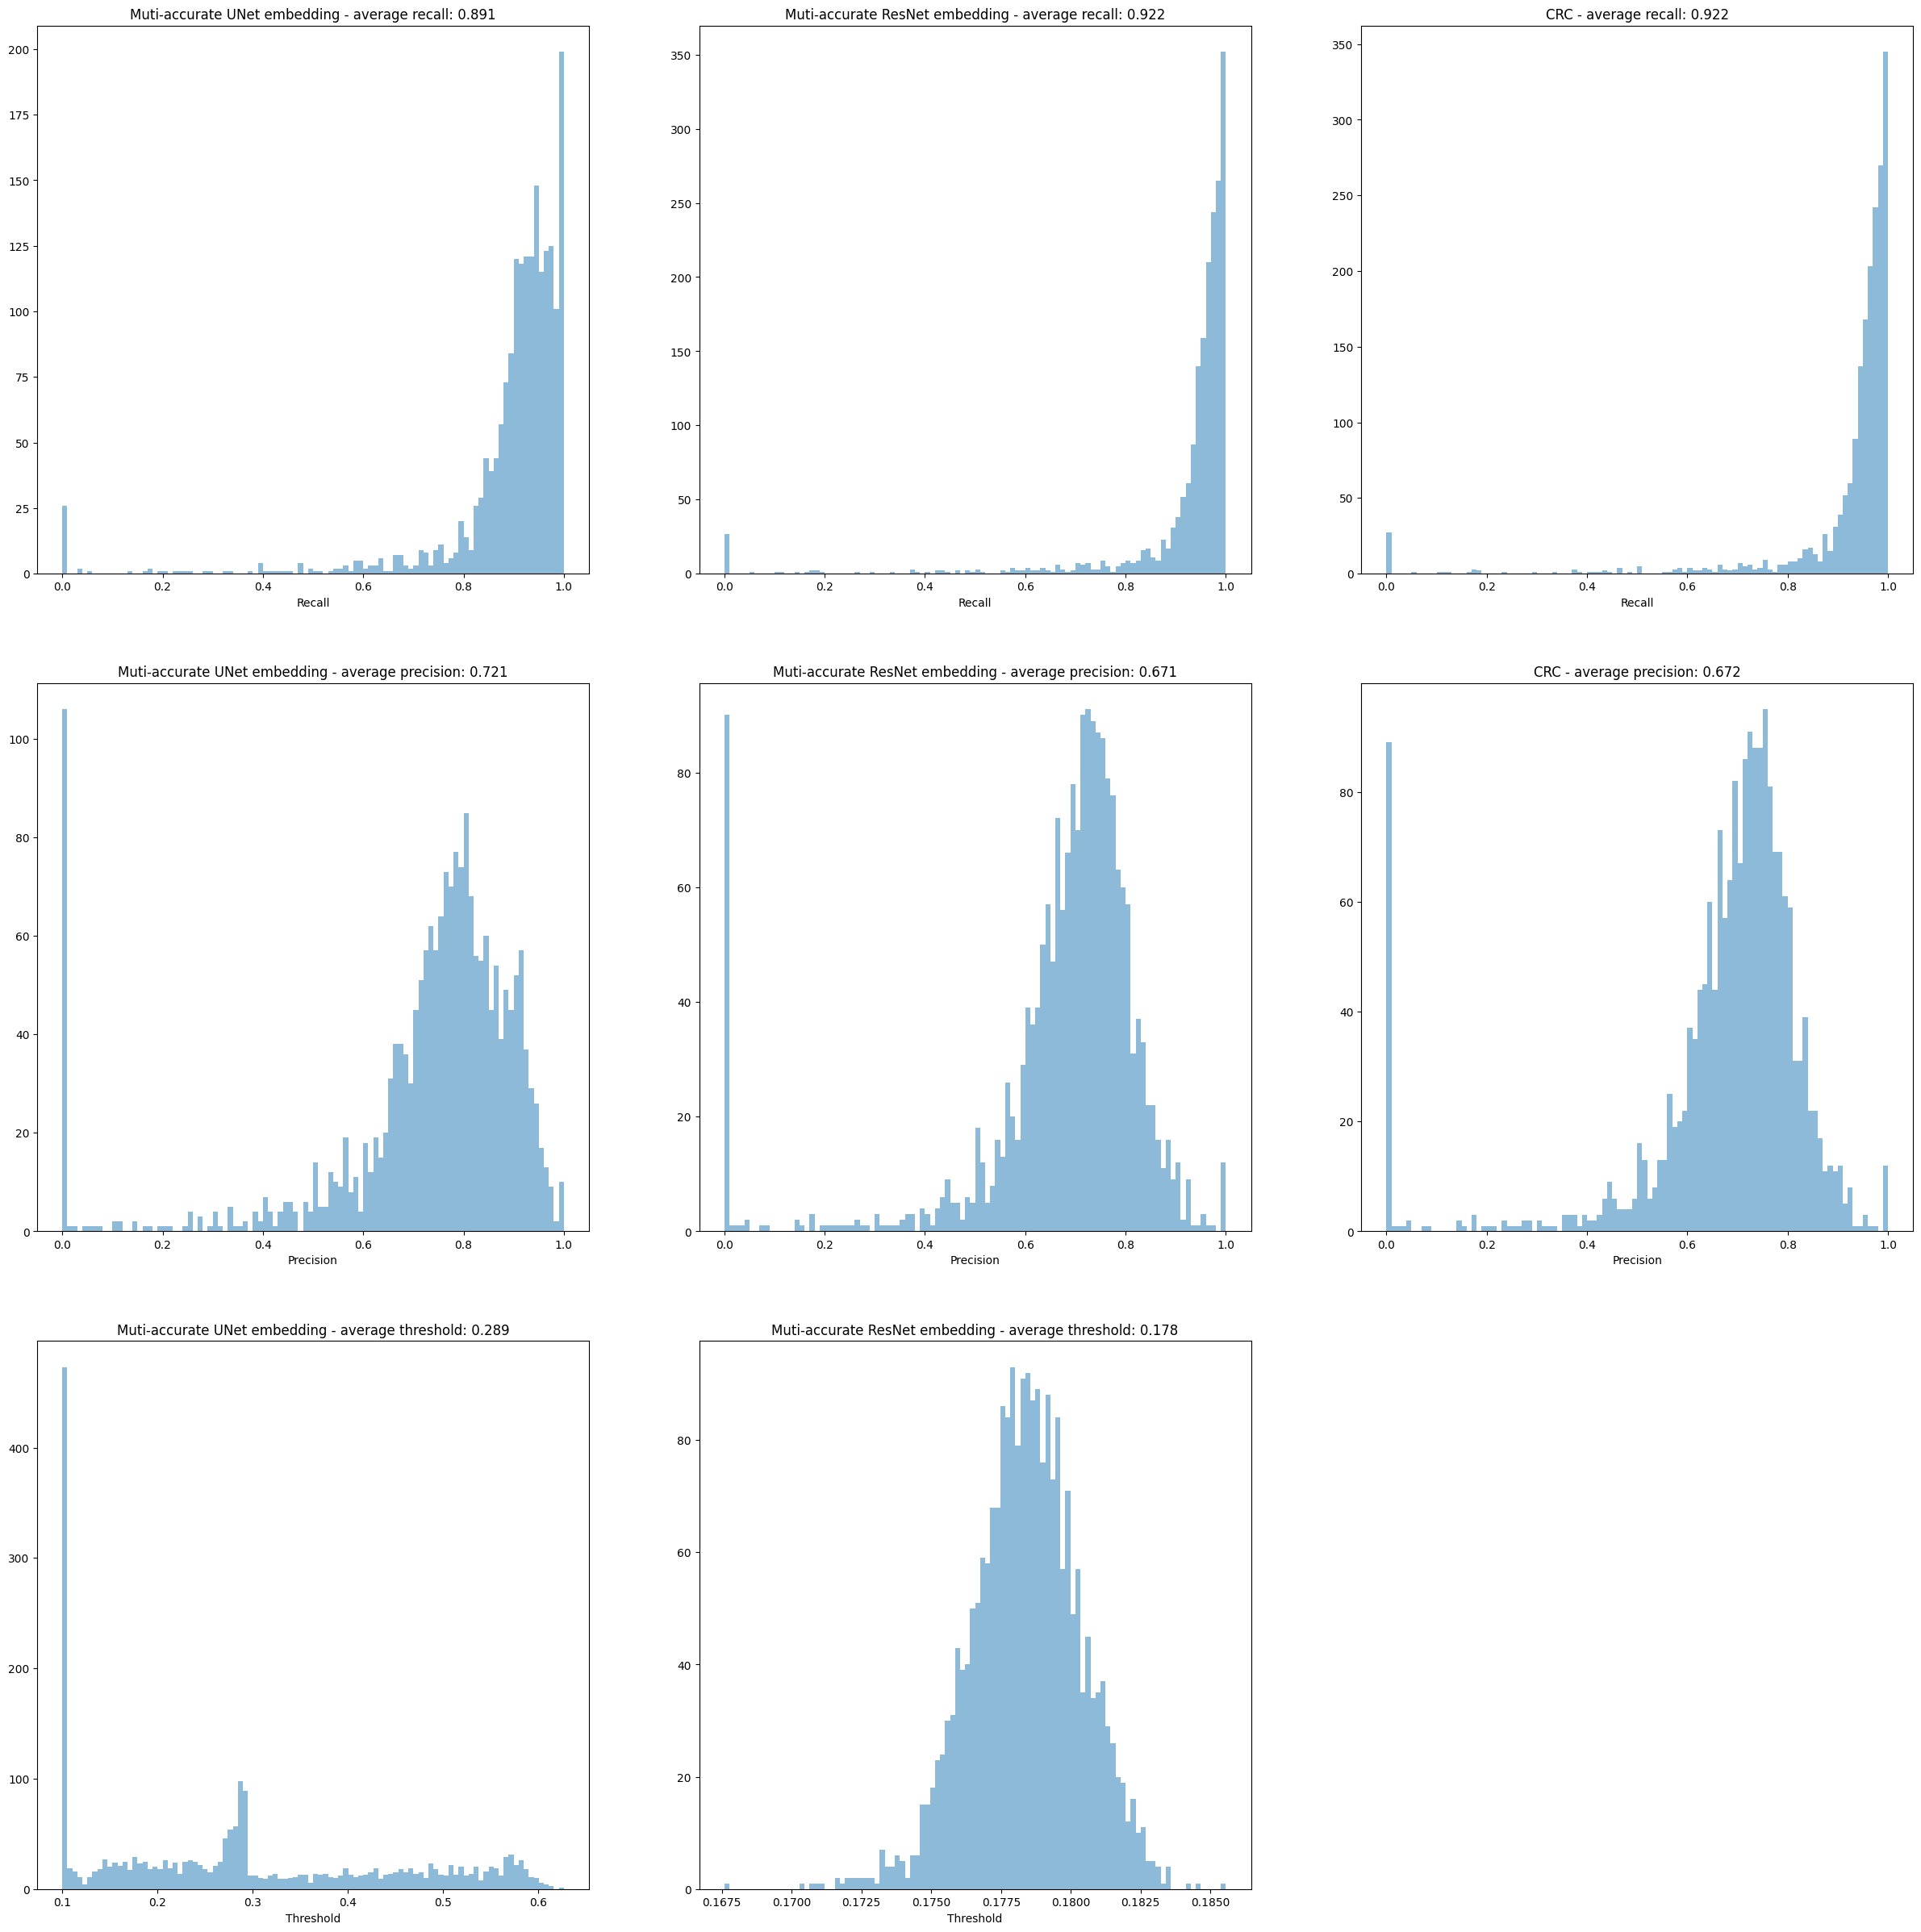

In [38]:
s = 10
nrow = 3
ncol = 3
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))

ax[0, 0].hist(recall_unet, bins=100, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate UNet embedding - average recall: {np.nanmean(recall_unet):.3f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recall_resnet, bins=100, alpha=.5)
ax[0, 1].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recall_resnet):.3f}")
ax[0, 1].set_xlabel("Recall")

ax[0, 2].hist(recall_test_crc, bins=100, alpha=.5)
ax[0, 2].set_title(f"CRC - average recall: {np.nanmean(recall_test_crc):.3f}")
ax[0, 2].set_xlabel("Recall")

ax[1, 0].hist(precision_test_unet, bins=100, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate UNet embedding - average precision: {np.nanmean(precision_test_unet):.3f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precision_test_resnet, bins=100, alpha=.5)
ax[1, 1].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precision_test_resnet):.3f}")
ax[1, 1].set_xlabel("Precision")

ax[1, 2].hist(precision_test_crc, bins=100, alpha=.5)
ax[1, 2].set_title(f"CRC - average precision: {np.nanmean(precision_test_crc):.3f}")
ax[1, 2].set_xlabel("Precision")

ax[2, 0].hist(ths_unet[:, 0, 0], bins=100, alpha=.5)
ax[2, 0].set_title(f"Muti-accurate UNet embedding - average threshold: {np.nanmean(ths_unet):.3f}")
ax[2, 0].set_xlabel("Threshold")

ax[2, 1].hist(ths_res[:, 0, 0], bins=100, alpha=.5)
ax[2, 1].set_title(f"Muti-accurate ResNet embedding - average threshold: {np.nanmean(ths_res):.3f}")
ax[2, 1].set_xlabel("Threshold")

ax[2, 2].set_axis_off()

In [39]:
precision_test_crc

array([0.70740741, 0.71220401, 0.76749436, ..., 0.43490305, 0.65946561,
       0.7114094 ])

In [23]:
precision_test_resnet

array([0.70740741, 0.7045045 , 0.76749436, ..., 0.43681319, 0.65946561,
       0.71227856])

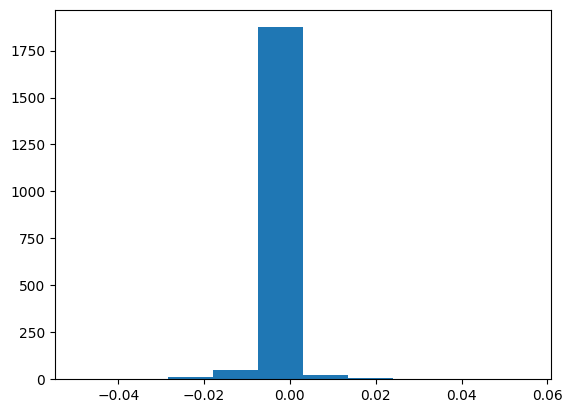

In [24]:
plt.hist(precision_test_resnet - precision_test_crc)
plt.show()

In [25]:
np.nanmean((precision_test_resnet - precision_test_crc))

-0.0012704638943564213

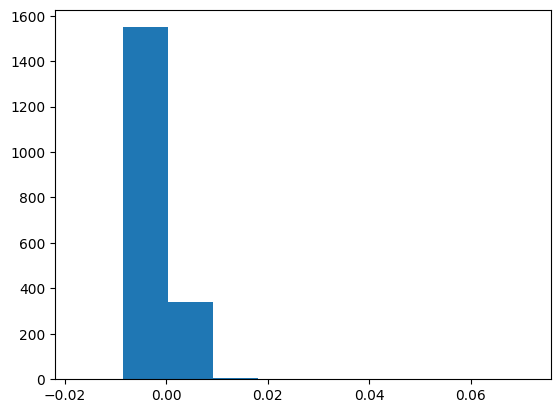

In [26]:
plt.hist(recall_resnet - recall_test_crc)
plt.show()

In [27]:
np.nanmean(precision_test_unet)
t_unet = []
for i in precision_test_unet:
    if i == 0:
        continue
    else:
        t_unet.append(i)

t_resnet = []
for i in precision_test_resnet:
    if i == 0:
        continue
    else:
        t_resnet.append(i)

t_crc = []
for i in precision_test_crc:
    if i == 0:
        continue
    else:
        t_crc.append(i)

np.nanmean(t_unet), np.nanmean(t_resnet), np.nanmean(t_crc)

(0.7384775916068159, 0.7022805341865256, 0.7036104666035967)

In [28]:
np.nanmean(t)

NameError: name 't' is not defined

In [ ]:
len(precision_test_unet)

2300